## Описание проекта
Интернет-магазине продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно определить закономерности успешности игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
games[games['Name'].isna()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


### Вывод

Два значения не имеют названия игр, они же не имеют жанр. Также не полностью заполнены Critic_Score, User_Score и Rating. Возможно пропуски появились при парсинге данных. Так же предположу, что некоторых данных для стареньких игр просто нет.

### Шаг 2. Подготовьте данные

In [7]:
# нижний регистр названий столбцов
games.columns = games.columns.str.lower()

In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [9]:
# заполнил пустые значения года выпуска игры медианой (2007) и изменил тип на int
games['year_of_release'] = games['year_of_release'].fillna(2007).astype(int)

# удалил строки с пустыми названиями и у них же пустой жанр
games = games[~games['name'].isna()].copy()

# функция замены значений tbd в столбце 'user_score' на Nan
def rename_tbd_to_nan(user_score):
    if user_score == 'tbd':
        return np.nan
    else:
        return user_score
    
games['user_score'] = games['user_score'].apply(rename_tbd_to_nan)

# изменил тип на float
games['user_score'] = games['user_score'].astype(float)

In [10]:
# Рейтинги critic_score и user_score начинают появляться для разных жанров по разному, но в основном с 1996 года.
# Игры, выходившие ранее, уберу из анализа. 
games_after_1995 = games[games['year_of_release'] > 1995]

# Группировка значений по жанру и году выпуска игры
genre_year_mean = games_after_1995.groupby(['genre','year_of_release']).mean().reset_index()

In [11]:
genre_year_mean

,genre,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
0,Action,1996,0.532500,0.294000,0.131000,0.072500,89.333333,8.700000
1,Action,1997,0.464516,0.318065,0.061290,0.046129,86.000000,8.550000
2,Action,1998,0.457955,0.270455,0.126136,0.041136,84.333333,8.680000
3,Action,1999,0.372750,0.217000,0.072500,0.031000,74.000000,8.300000
4,Action,2000,0.404318,0.246364,0.085000,0.036591,61.294118,6.862500
...,...,...,...,...,...,...,...,...
247,Strategy,2012,0.063333,0.063333,0.074000,0.016667,82.600000,7.840000
248,Strategy,2013,0.121053,0.127895,0.043158,0.030000,67.125000,4.633333
249,Strategy,2014,0.020000,0.027500,0.070000,0.005000,80.500000,6.800000
250,Strategy,2015,0.036250,0.061250,0.010000,0.008125,71.500000,7.062500


In [12]:
games_after_1995.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16008 entries, 0 to 16714
Data columns (total 11 columns):
name               16008 non-null object
platform           16008 non-null object
year_of_release    16008 non-null int64
genre              16008 non-null object
na_sales           16008 non-null float64
eu_sales           16008 non-null float64
jp_sales           16008 non-null float64
other_sales        16008 non-null float64
critic_score       8133 non-null float64
user_score         7586 non-null float64
rating             9944 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [13]:
games_after_1995['total_sales'] = (games_after_1995['na_sales'] + games_after_1995['eu_sales'] + 
                                   games_after_1995['jp_sales'] + games_after_1995['other_sales'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
games['total_sales'] = (games['na_sales'] + games['eu_sales'] + 
                        games['jp_sales'] + games['other_sales'])

In [15]:
games_after_1995.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16008 entries, 0 to 16714
Data columns (total 12 columns):
name               16008 non-null object
platform           16008 non-null object
year_of_release    16008 non-null int64
genre              16008 non-null object
na_sales           16008 non-null float64
eu_sales           16008 non-null float64
jp_sales           16008 non-null float64
other_sales        16008 non-null float64
critic_score       8133 non-null float64
user_score         7586 non-null float64
rating             9944 non-null object
total_sales        16008 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


### Вывод

TBD = to be determined, оценки игр, возможно, будут представлены позже. Эти значения поменял на значения NaN.
Пустые значения оценки критиков и пользователей заполнил средними значениями по жанру и году выхода игры. Годы выпуска заполнил медианой всех игр. Пропуски, я думаю, возникли при парсинге информации. Пустые значения рейтингов игр не заполнял.
Для дальнейшего анализа оставил игры, которые выпустили после 1995 года, так как оценки критиков и пользователей начали появляться с 1996 года, но для некоторых жанров и позже на год или два.

### Шаг 3. Проведите исследовательский анализ данных

#### Кол-во игр в год

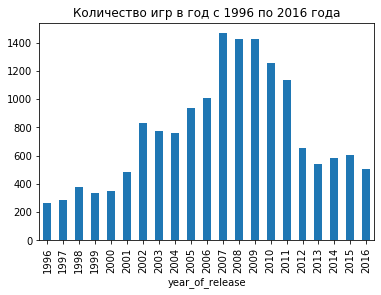

In [16]:
# график количества выпущенных за один год с 1996 по 2016 года
games_after_1995.groupby('year_of_release').count()['name'].plot(kind='bar', title='Количество игр в год с 1996 по 2016 года');

#### Продажи по годам 

Text(0, 0.5, 'Продажи, млн.$')

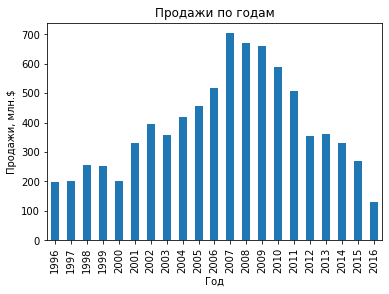

In [17]:
sales_by_year = games_after_1995.groupby('year_of_release').sum()['total_sales'].plot(kind='bar', title='Продажи по годам');
sales_by_year.set_xlabel("Год")
sales_by_year.set_ylabel("Продажи, млн.$")

#### Продажи по платформам с 1996 по 2016 года

In [18]:
sales_platforms = games_after_1995.groupby(['platform']).sum()['total_sales'].sort_values(ascending=False)

Text(0, 0.5, 'Продажи, млн.$')

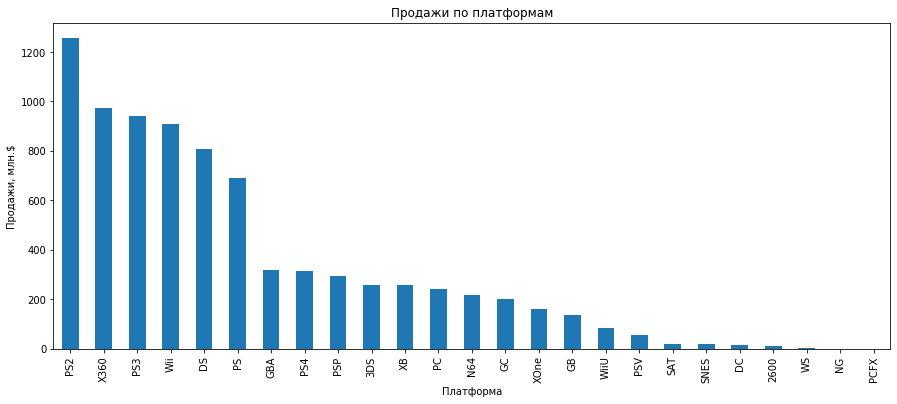

In [19]:
sales_platforms_plot = sales_platforms.plot(kind='bar', figsize=(15,6), title='Продажи по платформам')
sales_platforms_plot.set_xlabel("Платформа")
sales_platforms_plot.set_ylabel("Продажи, млн.$")

In [20]:
pt_year_platform_sales_sum = games_after_1995.pivot_table(index='year_of_release',
                                                          columns='platform', values='total_sales',
                                                          aggfunc='sum')

In [21]:
# первые 6 платформ продаются значительно больше, чем остальные
sales_platforms_top = list(sales_platforms.head(6).index)
sales_platforms_top

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Text(0, 0.5, 'Продажи, млн.$')

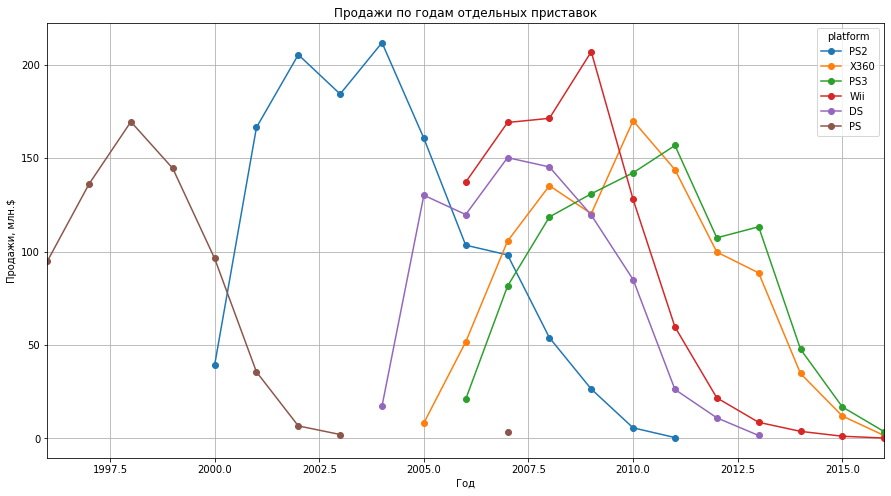

In [22]:
pt_year_platform_sales_sum_plot = pt_year_platform_sales_sum[sales_platforms_top]\
                                    .plot(figsize=(15,8), style='o-', grid=True, title='Продажи по годам отдельных приставок')
pt_year_platform_sales_sum_plot.set_xlabel("Год")
pt_year_platform_sales_sum_plot.set_ylabel("Продажи, млн.$")

In [23]:
# сколько лет продавались игры на платформы
pt_year_platform_sales_sum[sales_platforms_top].count().sort_values(ascending = False)

platform
X360    12
PS2     12
Wii     11
PS3     11
DS      10
PS       9
dtype: int64

In [24]:
pt_year_platform_sales_sum.count().sort_values(ascending = False).mean()

7.4

В среднем на платформу выпускают игры на протяжении 7-8 лет. 
Популярные приставки по продажам "жили" от 9 до 12 лет. Пик продаж игр на популярные приставки приходится через 4-6 лет, после выхода приставки. Актуальные период приму 6 лет. Для прогнозирования на 2017 год возму приставки, которые выходили позже 2011 года (включая 2011 год). 

#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [25]:
pt_year_platform_sales_sum.loc[2011:].T

year_of_release,2011,2012,2013,2014,2015,2016
platform,,,,,,
2600,NaN,NaN,NaN,NaN,NaN,NaN
3DS,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN
DS,26.18,11.01,1.54,NaN,NaN,NaN
GB,NaN,NaN,NaN,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN,NaN
N64,NaN,NaN,NaN,NaN,NaN,NaN
NG,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Продажи, млн.$')

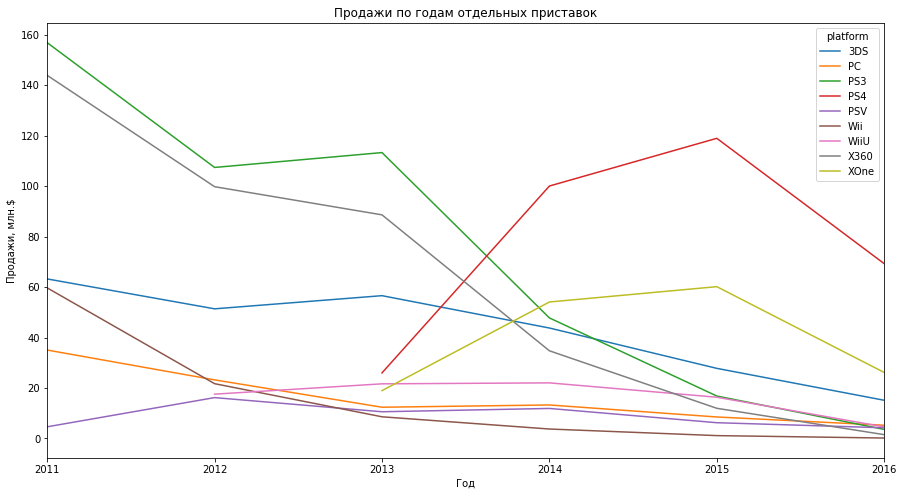

In [26]:
# на 6 платформ выпускали игры в период с 2011 по 2016 года и на 3 платформы начали выпускать в этот период
pt_year_platform_sales_sum_plot_2011 = (pt_year_platform_sales_sum
                                        .loc[2011:][['3DS', 'PC','PS3','PS4','PSV','Wii','WiiU', 'X360', 'XOne']]
                                        .plot(figsize=(15,8), title='Продажи по годам отдельных приставок'))
pt_year_platform_sales_sum_plot_2011.set_xlabel("Год")
pt_year_platform_sales_sum_plot_2011.set_ylabel("Продажи, млн.$")

Text(0, 0.5, 'Продажи, млн.$')

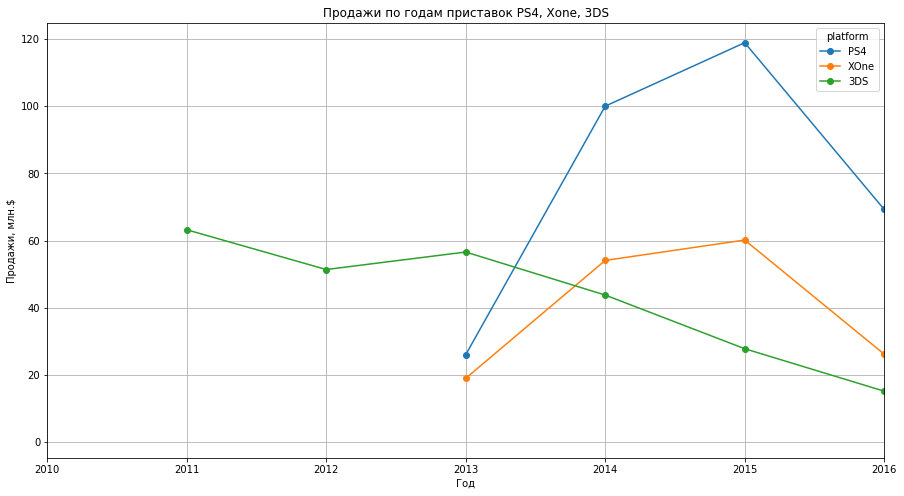

In [27]:
 platform_top_3_plot = pt_year_platform_sales_sum[[ 'PS4', 'XOne', '3DS']] \
            .plot(figsize=(15,8), style='o-', grid=True, xlim=(2010, 2016), title='Продажи по годам приставок PS4, Xone, 3DS')
platform_top_3_plot.set_xlabel("Год")
platform_top_3_plot.set_ylabel("Продажи, млн.$")

В 2016 год продажи игр на все платформы составил 130 млн.долларов. Этот год был плохой для игр. Но можно выделить 3 платформы (PS4, XOne, 3DS), на них пришлось в сумме 110 млн.долларов. Я считаю эти три платформы перспективными на следующий год и сделал бы упор на рекламу игр для этих платформ, не принимая во внимание, что продажи игр на PS4, XOne, 3DS упали по сравнению с 2015 годом.

#### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

(0, 4)

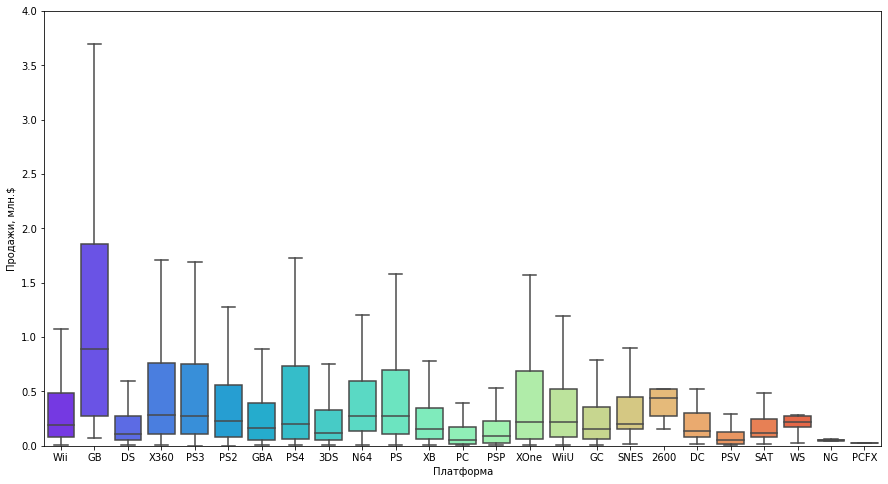

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(y="total_sales", x="platform", data = games_after_1995, palette='rainbow', showfliers=False, ax=ax)
ax.set_xlabel("Платформа")
ax.set_ylabel("Продажи, млн.$")
plt.ylim(0, 4)

(0, 2.5)

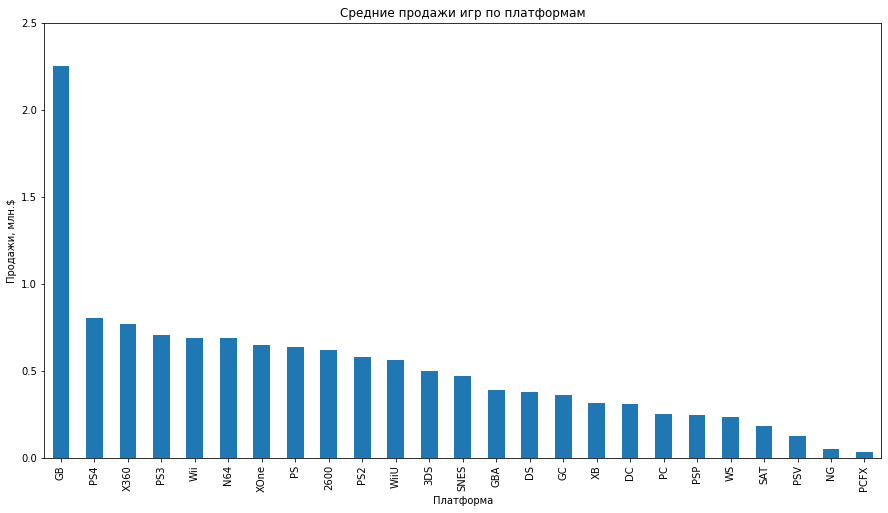

In [29]:
mean_total_sale_plot = games_after_1995.groupby('platform').mean()['total_sales'] \
                        .sort_values(ascending=False).plot(kind='bar', figsize=(15,8), 
                                                           title='Средние продажи игр по платформам')
mean_total_sale_plot.set_xlabel("Платформа")
mean_total_sale_plot.set_ylabel("Продажи, млн.$")
plt.ylim(0, 2.5)

In [30]:
games_after_1995.groupby('platform').agg({'total_sales':['mean','median']})

total_sales       
                mean median
platform                   
2600        0.617647  0.440
3DS         0.498077  0.120
DC          0.306731  0.135
DS          0.374930  0.110
GB          2.251311  0.890
GBA         0.386679  0.160
GC          0.357788  0.150
N64         0.685517  0.270
NG          0.050000  0.050
PC          0.249562  0.050
PCFX        0.030000  0.030
PS          0.637253  0.270
PS2         0.581106  0.230
PS3         0.705973  0.270
PS4         0.801378  0.200
PSP         0.243218  0.090
PSV         0.125744  0.055
SAT         0.180098  0.120
SNES        0.470000  0.200
WS          0.236667  0.215
Wii         0.687508  0.190
WiiU        0.559116  0.220
X360        0.769746  0.280
XB          0.312791  0.150
XOne        0.645020  0.220

Медиана продаж игр для платформы GB больше остальных игр. Это говорит о том, что игры продавались лучше остальных, но на платформу GB после 1995 года было выпущено всего 61 игра судя по данным и предположу что в данных представлены лучшие игры этой приставки. В среднем медиана продаж игр находится в промежутке от 0.03 до 0.5 млн.$

Средние продажи игр у GB выше остальных приставок. У популярных приставок (от Sony и Microsoft) среднии продажи игр варьируются от 0.6 до 0.8 млн.$

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [31]:
games_after_1995.groupby('platform').sum()['total_sales'].sort_values(ascending=False)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.10
PS       688.87
GBA      317.85
PS4      314.14
PSP      294.05
3DS      259.00
XB       257.74
PC       239.33
N64      218.68
GC       198.93
XOne     159.32
GB       137.33
WiiU      82.19
PSV       54.07
SAT       18.37
SNES      17.39
DC        15.95
2600      10.50
WS         1.42
NG         0.10
PCFX       0.03
Name: total_sales, dtype: float64

In [35]:
ps2_score_sales = games_after_1995[games_after_1995['platform'] == 'PS2'][['critic_score', 'user_score', 'total_sales']]

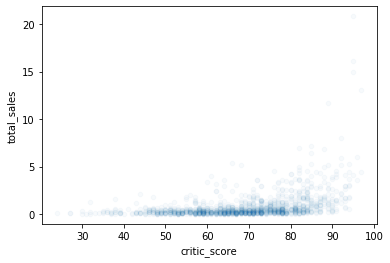

In [36]:
ps2_score_sales.plot(x='critic_score', y='total_sales', style='o', kind='scatter', alpha=0.03)

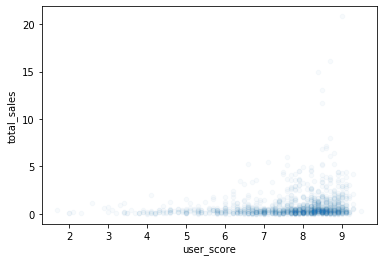

In [37]:
ps2_score_sales.plot(x='user_score', y='total_sales', style='o', kind='scatter', alpha=0.03)

In [38]:
ps2_score_sales['total_sales'].corr(ps2_score_sales['critic_score'])

0.3954345494545487

In [39]:
ps2_score_sales['total_sales'].corr(ps2_score_sales['user_score'])

0.17286551112058213

Продажи сильнее зависят от оценок критиков, чем от оценок обычных обычных игроков.

In [40]:
critic_score_corr = []
user_score_corr = []

for platform in games_after_1995['platform'].unique():
    df_platform_score_sales = games_after_1995[games_after_1995['platform'] == platform][['critic_score', 'user_score', 'total_sales']]
    critic_corr = df_platform_score_sales['total_sales'].corr(df_platform_score_sales['critic_score'])
    user_corr = df_platform_score_sales['total_sales'].corr(df_platform_score_sales['user_score'])
    critic_score_corr.append(critic_corr)
    user_score_corr.append(user_corr)

In [41]:
score = {'critic_score': critic_score_corr, 'user_corr': user_score_corr}
pd.DataFrame(index=games_after_1995['platform'].unique(), data=score)

,critic_score,user_corr
Wii,0.177560,0.112414
GB,NaN,NaN
DS,0.236379,0.130436
X360,0.393736,0.114459
PS3,0.432432,0.126691
PS2,0.395435,0.172866
GBA,0.239101,0.100758
PS4,0.406568,-0.031957
3DS,0.349401,0.224808
N64,NaN,NaN


Продажа игр на большинство платформ зависит от оценок критиков больше, как и для PS2. 

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Text(0, 0.5, 'Продажи, млн.$')

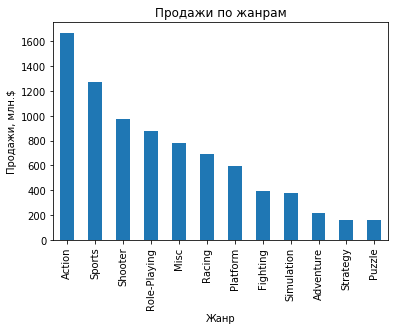

In [42]:
sales_genre_sum_plot = games_after_1995.groupby('genre').sum()['total_sales'].sort_values(ascending=False).plot(kind='bar', title='Продажи по жанрам')
sales_genre_sum_plot.set_xlabel("Жанр")
sales_genre_sum_plot.set_ylabel("Продажи, млн.$")

Жанр игр 'Action' самый продаваемый. Самые не продаваемые жанры это - 'Puzzle', 'Strategy', 'Adventure'.

#### Вывод

На популярные платформы (Sony и Microsoft) выпускают игры до 12 лет. И следующие поколения этих приставок также имеют успех. Поэтому поставил бы на рекламу игр для таких приставое как PS4 и XOne.

### Шаг 4. Составьте портрет пользователя каждого региона

Text(0, 0.5, 'Продажи, млн.$')

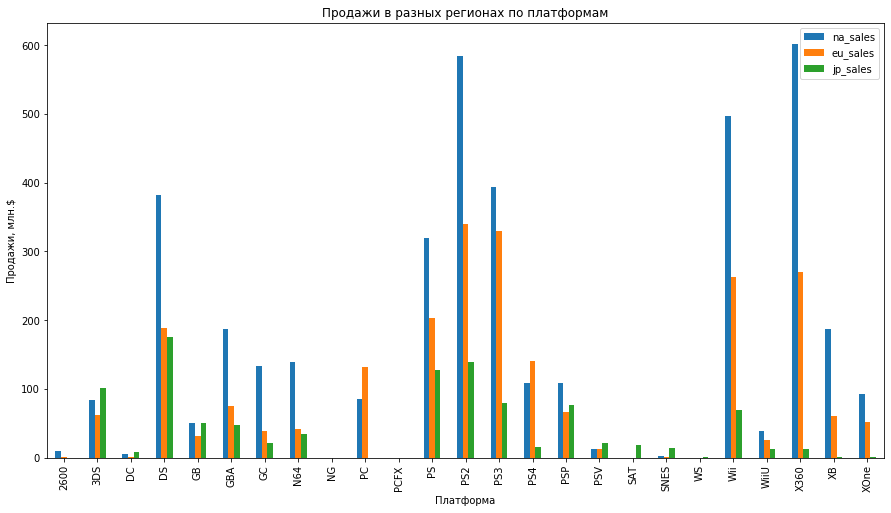

In [43]:
sales_platform_regions = games_after_1995.groupby('platform').sum()[['na_sales', 'eu_sales', 'jp_sales']] \
        .plot(kind='bar', figsize=(15,8), title='Продажи в разных регионах по платформам')
sales_platform_regions.set_xlabel("Платформа")
sales_platform_regions.set_ylabel("Продажи, млн.$")

Продажи в Северной Америке на всех платформах (кроме 3DS) превышают. Самые не играющие оказались японцы, и больше всего поддерживают  платформу DS. Продажи игр для платформ PS2, PS3, Wii и X360 во всех регионах превышают над другими платформами.

Text(0, 0.5, 'Продажи, млн.$')

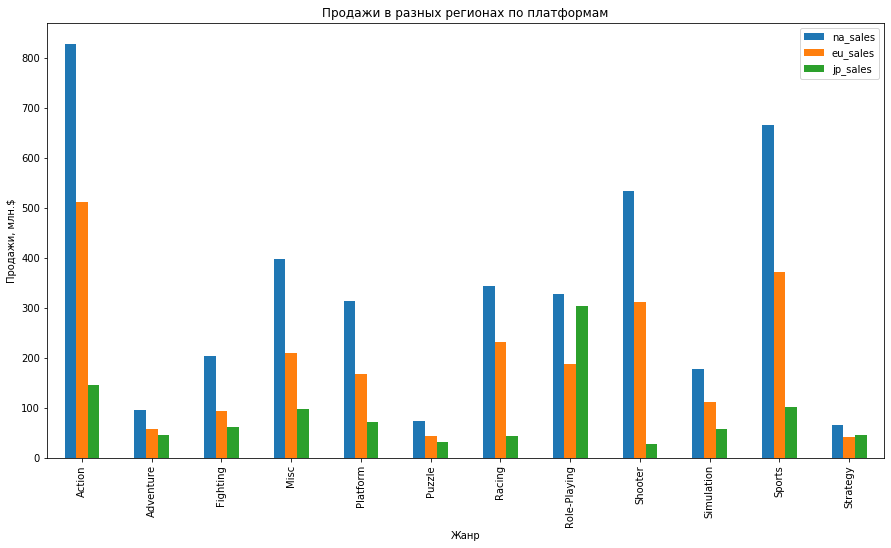

In [44]:
sales_genre_regions = games_after_1995.groupby('genre').sum()[['na_sales', 'eu_sales', 'jp_sales']] \
        .plot(kind='bar', figsize=(15,8), title='Продажи в разных регионах по платформам')
sales_genre_regions.set_xlabel("Жанр")
sales_genre_regions.set_ylabel("Продажи, млн.$")

Text(0, 0.5, 'Продажи, млн.$')

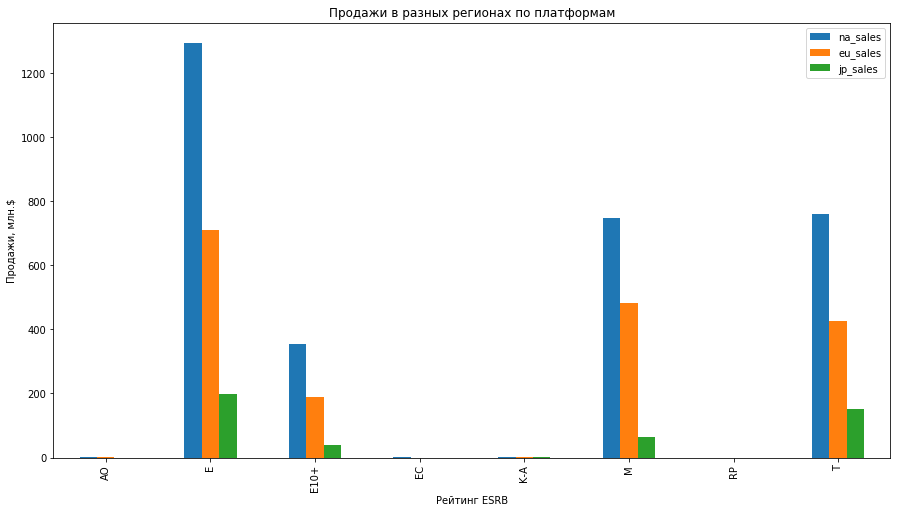

In [45]:
sales_esrb_regions = games_after_1995.groupby('rating').sum()[['na_sales', 'eu_sales', 'jp_sales']] \
        .plot(kind='bar', figsize=(15,8), title='Продажи в разных регионах по платформам')
sales_esrb_regions.set_xlabel("Рейтинг ESRB")
sales_esrb_regions.set_ylabel("Продажи, млн.$")

В Северной Америке играли больше на приставках DS, PS, PS2, PS3, Wii, X360. Их любимые жанры action, shooter, sports и больше всего играли в игры с рейтингом E ('для всех'). Рейтинги М('для взрослых') и Т ('подросткам') менее популярны и примерно равны между собой.
В Европе также популярны DS, PS2, PS3, Wii, X360. Интересно заметить, что европейцы больше всех играли на комьютере (PC). Вкусы популярных жанров не отличаются от американских, как и рейтинги
В Японии больше играли на платформах DS, PS, PS2. Популярные жанр у японце role-playing. И лучше продабтся игры с рейтингами E ('для всех') и Т ('подросткам').

### Шаг 5. Проверьте гипотезы

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

In [56]:
xone_user_score = games_after_1995.query('platform== "XOne" and user_score')['user_score']
pc_user_score = games_after_1995.query('platform== "PC" and user_score')['user_score']

Применю гипотезу о равенстве средних двух генеральных совокупностей. Приму,что разные платформы для игр - разные генеральные совокупности.

Нулевая гипотиза: средние пользовательские рейтинги платформ Xbox One и PC равны.
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [57]:
alpha = 0.05

results = st.ttest_ind(xone_user_score, pc_user_score)
print('p-value = ', results.pvalue)

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу (средние пользовательские рейтинги платформ Xbox One и PC не равны)')
else:
    print('Нулевую гипотезу отвергать нельзя (средние пользовательские рейтинги платформ Xbox One и PC равны)')

p-value =  1.0065420479826604e-05
Принимаем альтернативную гипотезу (средние пользовательские рейтинги платформ Xbox One и PC не равны)


#### Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные

In [58]:
action_user_score = games_after_1995.query('genre== "Action" and user_score')['user_score']
sports_user_score = games_after_1995.query('genre== "Sports" and user_score')['user_score']

Применю гипотезу о равенстве средних двух генеральных совокупностей. Приму,что разные жанры игр - это разные генеральные совокупности.

Нулевая гипотиза: средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.

In [59]:
alpha = 0.05

results = st.ttest_ind(action_user_score, sports_user_score)
print('p-value = ', results.pvalue)

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу (средние пользовательские рейтинги жанров Action и Sports не равны)')
else:
    print('Нулевую гипотезу отвергать нельзя (средние пользовательские рейтинги жанров Action и Sports равны)')

p-value =  0.10406951359049141
Нулевую гипотезу отвергать нельзя (средние пользовательские рейтинги жанров Action и Sports равны)


### Шаг 6. Общий вывод

Предлагается сделать упор на игры для платформ, которые имеют несколько поколений развития. Это в первую очередь приставки Sony, Microsoft и Nintendo. 
Стоит учесть популярные жанры: action, shooter, sports, role-playing. 
Для Европы и Северной Америки можно ориентироваться на одну стратегию развития рекламной кампании. Для Японии стоит оринетирроваться на другую стратегию, подходящию для игроков этой страны. 
Не стоит только ориентироваться на игры с высокими оценками критиков, потому что общие продажи мало коррелириют с этими оценками.
В проботе были проанализированы продажи платформ по годам. По этим данным была найдена среднее кол-во, сколько платформа существует. Определн актуальный период для прогнозирования. Составлен портрет игроков для трех регирнов. Определена зависимоть общих продаж на оценки критиков и пользователей. В конце были проверены гипотезы равенства средних оценок пользователей для платформ XOne и PC и жанров Action и Sports.